In [1]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# from Models import attention_unet as AttnUNet, vanilla_unet as UNet
from Models.attention_unet import AttnUNet
from Models.unet import UNet


%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [7]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_mask_pairs = []
        self.transform = transform

        # Loop through all patient folders
        for patient_folder in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_folder)
            if not os.path.isdir(patient_path):
                continue

            # Collect image–mask pairs
            for file in os.listdir(patient_path):
                if file.endswith(".tif") and "_mask" not in file:
                    image_path = os.path.join(patient_path, file)
                    mask_path = image_path.replace(".tif", "_mask.tif")
                    if os.path.exists(mask_path):
                        self.image_mask_pairs.append((image_path, mask_path))

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binary mask

        return image, mask

In [15]:
# model = AttnUNet(input_channels=3, out_channels=1, channels=[32, 64, 128, 256]).to(device)
# model = AttnUNet(input_channels=3, out_channels=1, channels=[64, 128, 256, 512]).to(device)
model = UNet(in_channels=3, out_channels=1, channels=[64, 128, 256, 512]).to(device)
# model = UNet(in_channels=3, out_channels=1, channels=[32, 64, 128, 256]).to(device)

state_dict = torch.load("saved_parameters/unet_im128_in64_o512_b32_e50_dice88.pth", map_location=device)
model.load_state_dict(state_dict=state_dict, strict=False)

lr= 3e-4
batch_size = 32
epochs = 50
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
crterion = nn.BCEWithLogitsLoss()

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset_root = r"data/kaggle_3m"  # Update this path to your dataset location
dataset = BrainMRIDataset(root_dir=dataset_root, transform=transform)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
val_size=  0.2
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
train_idx, val_idx = indices[split: ], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(dataset, batch_size=batch_size , sampler=train_sampler)
val_loader = DataLoader(dataset,batch_size=batch_size ,sampler=val_sampler)

In [ ]:
# images, masks = next(iter(train_loader))
# print(F"{images.shape =}")
# plt.figure(figsize=(12, 6))
# for i in range(4):
#     plt.subplot(2, 4, i+1)
#     plt.imshow(images[i].permute(1, 2, 0))
#     plt.title("MRI Slice")

#     plt.subplot(2, 4, i+5)
#     plt.imshow(masks[i][0], cmap='gray')
#     plt.title("Tumor Mask")

# plt.tight_layout()
# plt.show()

In [ ]:
## try forward pass one input
with torch.no_grad():
    for images, masks in tqdm(train_loader):
        print(f"Input shape: {images.shape}, Mask shape: {masks.shape}")
        break
        
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = crterion(outputs, masks)

        # Get predictions
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        # plt.figure(figsize=(12, 4))

        # plt.subplot(1, 3, 1)
        # plt.imshow(images[0].cpu().permute(1, 2, 0))
        # plt.title("Input MRI")

        # plt.subplot(1, 3, 2)
        # plt.imshow(masks[0][0].cpu(), cmap='gray')
        # plt.title("Ground Truth Mask")

        # plt.subplot(1, 3, 3)
        # plt.imshow(preds[0][0].cpu(), cmap='gray')
        # plt.title("Predicted Mask")

        # plt.show()
        break

In [ ]:
for epoch in range(epochs):
    model.train()
    runing_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for idx, (image, mask) in enumerate(train_loader_tqdm):
        # if idx == 0:
        #     print(f"Input shape: {image.shape}, Mask shape: {mask.shape}")
        image = image.float().to(device)
        mask = mask.float().to(device)
        
        out = model(image)
        optimizer.zero_grad()
        loss = crterion(out, mask)
        runing_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_loader_tqdm.set_postfix(loss=loss.item())
    train_loss = runing_loss / (idx + 1)
    model.eval()
    val_loss_runinig = 0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
    with torch.no_grad():
        for idx, (image, mask) in enumerate(val_loader_tqdm):
            image = image.float().to(device)
            mask = mask.float().to(device)
            out = model(image)
            loss = crterion(out, mask)
            val_loss_runinig += loss.item()
            val_loader_tqdm.set_postfix(loss=loss.item())
        val_loss = val_loss_runinig / (idx + 1)
        print(f"Epoch : {epoch + 1} ... Train Loss:{train_loss : .4f}....Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), "UNet1.pth")

In [9]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = torch.flatten(y_true)
    y_pred_flatten = torch.flatten(y_pred)

    intersection = torch.sum(y_true_flatten * y_pred_flatten)
    union = torch.sum(y_true_flatten) + torch.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = torch.sum(y_true * y_pred)
    sum = torch.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [20]:
# Evaluate the trained model on the validation dataset
model.eval()
total_loss = 0.0
total_dice = 0.0
total_iou = 0.0
num_batches = 0

with torch.no_grad():
    for image, mask in tqdm(val_loader, desc="Validating"):
        image = image.float().to(device)
        mask = mask.float().to(device)
        output = model(image)
        loss = crterion(output, mask)
        probs = torch.sigmoid(output)
        dice = dice_coef(mask, probs)
        iou = iou_coef(mask, probs)

        total_loss += loss.item()
        total_dice += dice.item()
        total_iou += iou.item()
        num_batches += 1

mean_loss = total_loss / num_batches
mean_dice = total_dice / num_batches
mean_iou = total_iou / num_batches

print(f"Validation Loss: {mean_loss:.4f}, Dice Score: {mean_dice:.4f}, IoU Score: {mean_iou:.4f}")


Validating: 100%|██████████| 25/25 [00:04<00:00,  5.70it/s]

Validation Loss: 0.0039, Dice Score: 0.9087, IoU Score: 0.8346


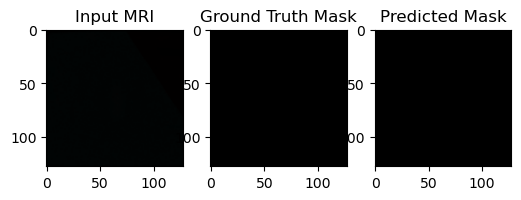

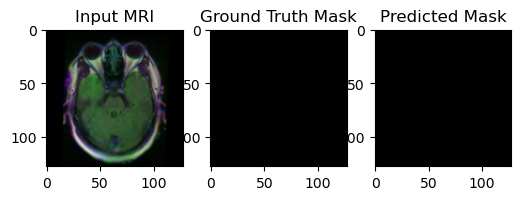

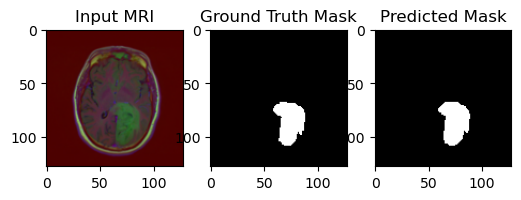

In [29]:
with torch.no_grad():
    for i, (image, mask) in enumerate(val_loader):
        image = image.to(device)
        mask = mask.to(device)

        output = model(image)               # raw logits
        probs = torch.sigmoid(output)       # probabilities
        preds = (probs > 0.5).float()       # binary mask

        # Optional: visualize
        if i < 3:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(6, 2))

            plt.subplot(1, 3, 1)
            plt.imshow(image[0].cpu().permute(1, 2, 0))
            plt.title("Input MRI")

            plt.subplot(1, 3, 2)
            plt.imshow(mask[0][0].cpu(), cmap='gray')
            plt.title("Ground Truth Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[0][0].cpu(), cmap='gray')
            plt.title("Predicted Mask")

            plt.show()